In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import pymc3 as pm
import theano.tensor as tt
import arviz as az

print("Running on PyMC3 v{}".format(pm.__version__))

Running on PyMC3 v3.8


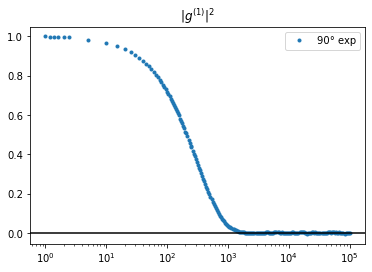

In [3]:
from MultiAngleDls import multiAngleDls

filelist = ['test_data\PS_80nm_90degree.dat']
data = multiAngleDls(filelist, d_min=1, d_max=300, d_num=50)
data.plotOriginalData()  

In [4]:
model = pm.Model()

# 3 numbers that may be used directly
n = data.d.size                       # d number
R = data.angleNum                     # angle number

# second derivative operator matrix
# for prior use
L2 = np.zeros((n, n))
for j in range(L2.shape[0]-2):
    L2[j, j], L2[j, j+1], L2[j, j+2] = 1, -2, 1

'''
def prior(N):
    # 这里可能需要使用tt里的矩阵乘法
    if tt.any(N<0).eval():
        return 0
    else:
        temp = tt.sum(tt.dot(L2, N)**2)
        return tt.exp(-1*temp)
'''
# 构建 prior
from pymc3.distributions.continuous import BoundedContinuous
from pymc3.distributions.dist_math import bound

class prior(BoundedContinuous):

    def __init__(self, lower=np.zeros((n, 1)), L2=L2, *args, **kwargs):
        self.lower = lower = tt.as_tensor_variable(lower)
        self.L2 = L2

        super().__init__(lower=lower,  *args, **kwargs)

    def logp(self, value):
        # value here is N
        lower = self.lower
        return bound(-1*tt.sum(tt.dot(L2, value)**2), value >= lower)


'''
def likelihood(N):
    # N.shape = (n, 1)

    def _logp(g1square_exp):
        #N = N.reshape((N.size, 1))
        M = g1square_exp.size                # tau number
        C = data.C_theta_list[0]
        F = data.F_theta_list[0]
        #C = C.reshape((C.size, 1))
        CN = C*N
        g1square_theo = ( (1/CN.sum())*tt.dot(F, N) )**2
        chi = tt.sum( (g1square_exp - g1square_theo)**2 )
        return tt.power(chi, -1*M/2)

    return _logp
'''

from pymc3.distributions import Continuous

tau = data.dlsDataList[0].tau * 1e-6
Gamma = 100
testg1square = np.exp(-1*Gamma*tau)**2
class likelihood(Continuous):

    def __init__(self, g1square_theo=testg1square, M=200,  *args, **kwargs):
        self.g1square_theo = g1square_theo = tt.as_tensor_variable(g1square_theo)
        self.M = M = tt.as_tensor_variable(M)

        super().__init__(*args, **kwargs)

    def logp(self, value):
        # value here is g1square
        g1square_theo = self.g1square_theo
        M = self.M
        return -M/2 * tt.log( tt.sum( (value - g1square_theo)**2 ) )



with model:

    # prior distribution
    #N = pm.DensityDist('N', prior, shape=(n,1))
    N = prior('N', lower=np.zeros((n, 1)), L2=L2, shape=(n,1), testval=np.ones((n, 1)))

    # likelihood function
    M = data.g1square_theta_list[0].size
    C = data.C_theta_list[0]
    C = C.reshape((C.size, 1))
    F = data.F_theta_list[0]
    CN = C*N
    g1square_theo = ( (1/CN.sum())*tt.dot(F, N) )**2

    like = likelihood('like', g1square_theo=g1square_theo, M=M, shape=(M,1), testval=testg1square, observed=data.g1square_theta_list[0])

In [5]:
with model:
    #step = pm.HamiltonianMC()
    #step = pm.Metropolis()
    step = pm.Slice()
    #step = pm.NUTS()
    trace = pm.sample(50000, step=step, cores=1, chains=1, tune=500000, discard_tuned_samples=True)
    #trace = pm.sample(50000, step=step, start=start, cores=1)
trace['N'].shape

Sequential sampling (1 chains in 1 job)
Slice: [N]
Sampling chain 0, 0 divergences: 100%|██████████| 55000/55000 [15:49<00:00, 57.92it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


(5000, 50, 1)

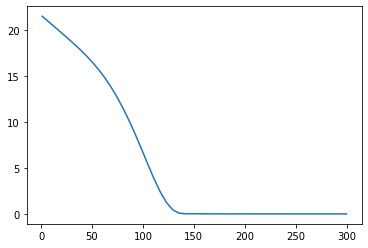

In [10]:
N_result = np.sum(trace['N'], axis=0) / trace['N'].shape[0]
plt.plot(data.d, N_result)
plt.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001AF6DADDEC8>,
      dtype=object)

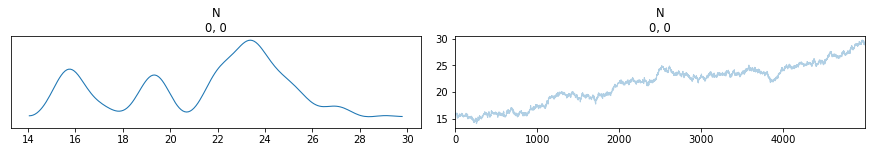

In [7]:
az.plot_trace(trace)

In [8]:
az.summary(trace)

arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shap

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
"N[0,0]",21.508,3.773,15.081,27.517,3.351,3.360,1.0,1.0,1.0,10.0,NaN
"N[1,0]",20.930,3.636,14.538,26.517,3.249,3.294,1.0,1.0,1.0,11.0,NaN
"N[2,0]",20.353,3.510,14.021,25.609,3.151,3.228,1.0,1.0,1.0,11.0,NaN
"N[3,0]",19.772,3.393,13.476,24.779,3.056,3.157,1.0,1.0,1.0,11.0,NaN
"N[4,0]",19.183,3.277,12.914,23.880,2.957,3.074,1.0,1.0,1.0,11.0,NaN
"N[5,0]",18.580,3.160,12.278,22.974,2.851,2.975,1.0,1.0,1.0,11.0,NaN
"N[6,0]",17.952,3.037,11.886,22.198,2.736,2.856,1.0,1.0,1.0,11.0,NaN
"N[7,0]",17.288,2.904,11.698,21.564,2.608,2.717,1.0,1.0,1.0,11.0,NaN
"N[8,0]",16.570,2.760,11.590,20.933,2.465,2.557,1.0,1.0,1.0,11.0,NaN
"N[9,0]",15.776,2.601,11.020,19.710,2.309,2.379,1.0,1.0,1.0,11.0,NaN


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001AF6E566DC8>],
      dtype=object)

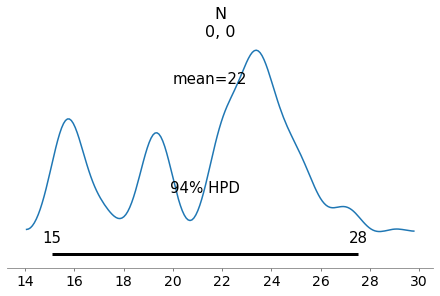

In [9]:
az.plot_posterior(trace)